In [1]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
import seaborn as sns

sns.set_theme()

In [2]:
def toDataFrame(t: torch.Tensor, origin: str):
    t = t.cpu().detach().numpy()
    df = pd.DataFrame(data=t, columns=(f"x{ix}" for ix in range(t.shape[1])))
    df['ix'] = df.index * 1.
    df["origin"] = origin
    return df

In [3]:
def scatterplots(samples: List[Tuple[str, torch.Tensor]], col_wrap=4):
    """Draw the 

    Args:
        samples (List[Tuple[str, torch.Tensor]]): The list of samples with their names
        col_wrap (int, optional): Number of columns in the graph. Defaults to 4.

    Raises:
        NotImplementedError: If the dimension of the data is not supported
    """
    # Convert data into pandas dataframes
    _, dim = samples[0][1].shape
    samples = [toDataFrame(sample, name) for name, sample in samples]
    data = pd.concat(samples, ignore_index=True)

    g = sns.FacetGrid(data, height=2, col_wrap=col_wrap, col="origin", sharex=False, sharey=False)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")

    if dim == 1:
        g.map(sns.kdeplot, "distribution")
        plt.show()
    elif dim == 2:
        g.map(sns.scatterplot, "x0", "x1", alpha=0.6)
        plt.show()
    else:
        raise NotImplementedError()

In [4]:
def iter_data(dataset: Dataset, bs):
    """Infinite iterator on dataset"""
    while True:
        loader = DataLoader(dataset, batch_size=bs, shuffle=True)
        yield from iter(loader)

In [5]:
class MLP(nn.Module):
    """Simple 4 layer MLP"""
    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, x):
        return self.net(x)

In [6]:
# --- Modules de base

class FlowModule(nn.Module):
    def __init__(self):
        super().__init__()

    def decoder(self, y) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns [f(x)] and log |det J_f(x)|"""
        ...

    def encoder(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns [f^{-1}(x)] and log |det J_f^{-1}(x)|"""
        ...

    def check(self, x: torch.Tensor):
        with torch.no_grad():
            (y, ), logdetj_1 = self.encoder(x)
            (hat_x, ), logdetj = self.decoder(y)

            # Check inverse
            delta = (x - hat_x).abs().mean()
            assert  delta < 1e-6, f"f(f^{-1}(x)) not equal to x (mean abs. difference = {delta})"

            # Check logdetj
            delta_logdetj = (logdetj_1 + logdetj).abs().mean()
            assert  delta_logdetj < 1e-6, f"log | J | not equal to -log |J^-1| (mean abs. difference = {delta_logdetj})"

In [7]:
class FlowSequential(FlowModule):
    """A container for a succession of flow modules"""
    def __init__(self, *flows: FlowModule):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def apply(self, modules_iter, caller, x):
        m, _ = x.shape
        logdet = torch.zeros(m, device=x.device)
        zs = [x]
        for module in modules_iter:
            gx, _logdet = caller(module, x)
            zs.extend(gx)
            logdet += _logdet

            x = gx[-1]
        return zs, logdet            

    def modulenames(self, decoder=False):
        return [f"L{ix} {module.__class__.__name__}" for ix, module in enumerate(reversed(self.flows) if decoder else self.flows)]

    def encoder(self, x):
        """Returns the sequence (z_K, ..., z_0) and the log det"""
        zs, logdet = self.apply(self.flows, (lambda m, x: m.encoder(x)), x)
        return zs, logdet

    def decoder(self, y):
        """Returns the sequence (z_0, ..., z_K) and the log det"""
        zs, logdet = self.apply(reversed(self.flows), (lambda m, y: m.decoder(y)), y)
        return zs, logdet

In [8]:
class FlowModel(FlowSequential):
    """Flow model = prior + flow modules"""
    def __init__(self, prior: torch.distributions.Distribution, *flows: FlowModule):
        super().__init__(*flows)
        self.prior = prior

    def encoder(self, x):
        # Computes [z_K, ..., z_0] and the sum of log det | f |
        zs, logdet = super().encoder(x)

        # Just computes the prior of $z_0$
        logprob = self.prior.log_prob(zs[-1])

        return logprob, zs, logdet

    def plot(self, data: torch.Tensor, n: int):
        """Plot samples together with ground truth (data)"""
        with torch.no_grad():
            d = data[list(np.random.choice(range(len(data)), n)), :]
            z0 = self.prior.sample((n, ))
            zs, _ = self.decoder(z0)

            data = [("data", d), ("dist", z0)] + list(zip(self.modulenames(decoder=True), zs[1:]))    
            scatterplots(data, col_wrap=4)

In [9]:
class Invertible1x1Conv(FlowModule):
    """ 
    As introduced in Glow paper.
    """
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        Q = torch.nn.init.orthogonal_(torch.randn(dim, dim))

        # Decompose Q in P (L + Id) (S + U)

        # https://pytorch.org/docs/stable/generated/torch.lu_unpack.html
        P, L, U = torch.lu_unpack(*Q.lu())

        # Not optimizated
        self.P = nn.Parameter(P, requires_grad=False)

        # Lower triangular
        self.L = nn.Parameter(L)

        # Diagonal
        self.S = nn.Parameter(U.diag())

        self.U = nn.Parameter(torch.triu(U, diagonal=1))

    def _assemble_W(self):
        """Computes W from P, L, S and U"""

        # https://pytorch.org/docs/stable/generated/torch.tril.html
        # Excludes the diagonal
        L = torch.tril(self.L, diagonal=-1) + torch.diag(torch.ones(self.dim, device=self.L.device))

        # https://pytorch.org/docs/stable/generated/torch.triu.html
        # Excludes the diagonal
        U = torch.triu(self.U, diagonal=1)

        W = self.P @ L @ (U + torch.diag(self.S))
        return W

    def decoder(self, y) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns [f^-1(x)] and log |det J_f^-1(x)|"""
        ...

    def encoder(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns [f(x)] and log |det J_f(x)|"""
        ...


## 3. Échauffement : Transformation affine

In [10]:
# TODO: Affine
class Affine(FlowModule):
    def __init__(self, d: int):
        super().__init__()
        self.s = nn.Parameter(torch.randn(d))
        self.t = nn.Parameter(torch.randn(d))

    def decoder(self, y):
        # f(y) = exp(s) * y + t
        f_y = y * torch.exp(self.s) + self.t

        # log |det J_f(y)| = sum(s)
        log_det_J_f = self.s.sum()

        return [f_y], log_det_J_f
    
    def encoder(self, x):
        # f_inv(x) = exp(-s) * (x - t)
        f_inv_x = (x - self.t) * torch.exp(-self.s)

        # log |det J_f_inv(x)| = -sum(s)
        log_J_f_inv_x = -self.s.sum()

        return [f_inv_x], log_J_f_inv_x

In [11]:
# 检查 Affine 类
affine = Affine(5)

affine.check(torch.randn(5))

Apprenez la transformation de $ z_0 \sim \mathcal{N}(0, 1) $ à $ x = z_1 \sim \mathcal{N}(\mu, \sigma) $

In [12]:
# (dim=1)
import torch.distributions as dist
import torch.optim as optim

# 定义目标分布
mu = torch.tensor([2.0])
sigma = torch.tensor([1.5])
target_dist = dist.Normal(mu, sigma)

# 定义模型
d = 1
model = Affine(d)

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 定义训练数据集: z0 ~ N(0,1)
batch_size = 100
z0_dist = dist.Normal(torch.zeros(d), torch.ones(d))

# 训练过程
num_epochs = 5000
for epoch in range(num_epochs):
    # 采样 z0
    z0 = z0_dist.sample((batch_size,))

    # 使用 affine_1 进行变换
    z1, log_det_J = model.decoder(z0)
    z1 = z1[0]

    # 计算 z1 的对数似然
    log_prob = target_dist.log_prob(z1).sum(dim=-1)

    # 最大化对数似然 -> 损失函数为负对数函数
    loss = -(log_prob + log_det_J).mean()

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 打印训练进度
    if (epoch+1) % 500 == 0:
        print(f"Epoch : {epoch+1} \t loss : {loss.item():.4f}")

# 打印学习到的参数
print(f"\nLearned s : {model.s.data.exp().item():.4f} \t Learned t : {model.t.data.item():.4f}")

# 生成样本进行验证
z0_sample = z0_dist.sample((100,))
z1_sample, _ = model.decoder(z0_sample)
z1_sample = z1_sample[0]

# 打印样本的均值和标准差
print(f"\nGenerated samples mean : {z1_sample.mean().item():.4f} \t Generated samples variance : {z1_sample.std().item():.4f}")
print(f"Target mean : {mu.item():.4f} \t\t\t Target variance : {sigma.item():.4f}")

Epoch : 500 	 loss : 1.4380
Epoch : 1000 	 loss : 1.4451
Epoch : 1500 	 loss : 1.3376
Epoch : 2000 	 loss : 1.4054
Epoch : 2500 	 loss : 1.4978
Epoch : 3000 	 loss : 1.3673
Epoch : 3500 	 loss : 1.3437
Epoch : 4000 	 loss : 1.4053
Epoch : 4500 	 loss : 1.4641
Epoch : 5000 	 loss : 1.3163

Learned s : 1.4978 	 Learned t : 2.0004

Generated samples mean : 2.0116 	 Generated samples variance : 1.7621
Target mean : 2.0000 			 Target variance : 1.5000


## 4. Glow (Part 1)

- Actnorm

In [13]:
class Actnorm(FlowModule):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.log_scale = nn.Parameter(torch.zeros(1, dim))  # s
        self.bias = nn.Parameter(torch.zeros(1, dim))       # t
        self.initialized = False

    def initialize_params(self, x):
        with torch.no_grad():
            self.bias.data = x.mean(dim=0, keepdim=True)
            self.log_scale.data = torch.log(x.std(dim=0, keepdim=True) + 1e-6)
        self.initialized = True

    def encoder(self, x):
        if not self.initialized:
            self.initialize_params(x)
        y = (x - self.bias) * torch.exp(-self.log_scale)
        log_det_jacobian = -self.log_scale.sum()
        return (y,), log_det_jacobian
    
    def decoder(self, y):
        x = y * torch.exp(self.log_scale) + self.bias
        log_det_jacobian = self.log_scale.sum()
        return (x,), log_det_jacobian

In [14]:
# 测试 Actnorm 
actnorm_test = Actnorm(5)

actnorm_test.check(torch.randn(5))

- Affine Coupling Layer

In [15]:
class AffineCoupling(FlowModule):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.scale_net = MLP(dim // 2, dim // 2, hidden_dim)
        self.shift_net = MLP(dim // 2, dim // 2, hidden_dim)

    def encoder(self, x):
        x1, x2 = x.chunk(2, dim=1)

        scale = self.scale_net(x1)
        shift = self.shift_net(x1)

        # scale = torch.tanh(scale) * 1.5  # 限制 scale 的范围 (-1.5, 1.5)

        y1 = x1
        y2 = x2 * torch.exp(scale) + shift
        log_det_jacobian = scale.sum(dim=1)

        return (torch.cat([y1, y2], dim=1),), log_det_jacobian
    
    def decoder(self, y):
        y1, y2 = y.chunk(2, dim=1)

        scale = self.scale_net(y1)
        shift = self.shift_net(y1)

        # scale = torch.tanh(scale) * 1.5  # 限制 scale 的范围 (-1.5, 1.5)
        
        x1 = y1
        x2 = (y2 - shift) * torch.exp(-scale)
        log_det_jacobian = -scale.sum(dim=1)
        return (torch.cat([x1, x2], dim=1),), log_det_jacobian

In [16]:
# 测试
affinecoupling_test = AffineCoupling(4, 128)

sample_test = torch.randn(8, 4)

affinecoupling_test.check(sample_test)

- Convolution 1x1 inversible

In [17]:
class Convolution1x1Inversible(Invertible1x1Conv):
    def __init__(self, dim):
        super().__init__(dim)

    def encoder(self, x):
        W = self._assemble_W()
        y = x @ W
        log_det_jacobian = torch.log(torch.abs(torch.det(W)))
        return (y,), log_det_jacobian
    
    def decoder(self, y):
        W = self._assemble_W()
        W_inv = torch.inverse(W)
        x = y @ W_inv
        log_det_jacobian = -torch.log(torch.abs(torch.det(W)))
        return (x,), log_det_jacobian

In [18]:
# 测试
conv1x1inv_test = Convolution1x1Inversible(5)

conv1x1inv_test.check(torch.randn(5))

/home/chen_guanyu/deepdac/lib/python3.10/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(


Tester un modèle Glow (10 couches alternant) en
utilisant des données jouet provenant de sklearn (mo ons) en utilisant une alternance de
10 couches ActNorm, Affine Coupling et Convolution1x1.

- Piror Gaussien

In [ ]:
from sklearn.datasets import make_moons

data, _ = make_moons(n_samples=1000, noise=0.05)
data = torch.tensor(data, dtype=torch.float32)

glow = FlowModel(
    torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)),
    *[FlowSequential(Actnorm(2), Convolution1x1Inversible(2), AffineCoupling(2, hidden_dim=128)) for _ in range(10)]
)

# 训练模型
optimizer = torch.optim.Adam(glow.parameters(), lr=1e-4)
num_epochs = 10000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    logprob, _, logdet = glow.encoder(data)
    loss = -(logprob + logdet).mean()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1} \t\t Loss: {loss.item():.4f}")

Epoch: 100 		 Loss: 0.7014
Epoch: 200 		 Loss: 0.5567
Epoch: 300 		 Loss: 0.4618
Epoch: 400 		 Loss: 0.3901
Epoch: 500 		 Loss: 0.3583
Epoch: 600 		 Loss: 0.3365
Epoch: 700 		 Loss: 0.3184
Epoch: 800 		 Loss: 0.3139
Epoch: 900 		 Loss: 0.3082
Epoch: 1000 		 Loss: 0.3292


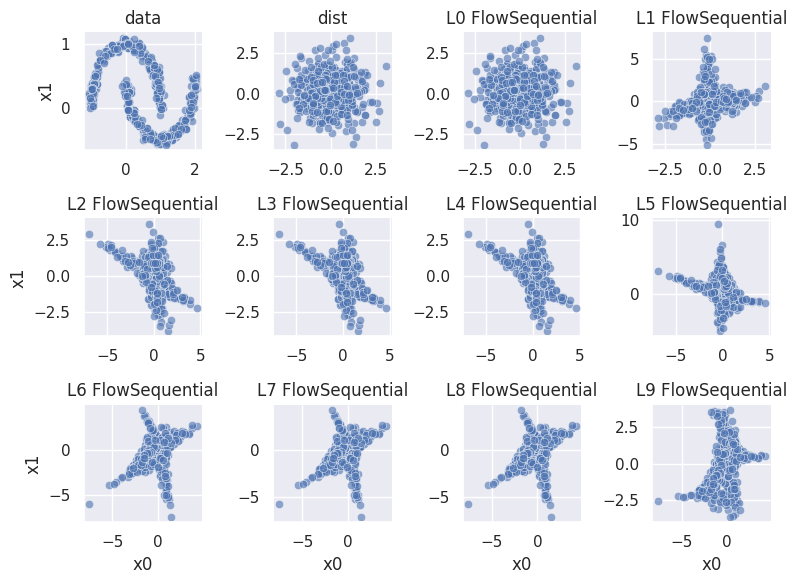

In [23]:
# 展示
glow.plot(data, n=1000)

- Piror mélange de 2 Gaussiennes (有问题，没法训练)

In [37]:
import torch.distributions as dist

# 定义二元混合高斯分布
means = torch.tensor([[0.5, 0.5],[-0.5, -0.5]])
stds = torch.ones(2,2)

# 权重矩阵
weights = torch.tensor([0.5,0.5])

mixture = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.ones(2)),
    component_distribution=dist.Independent(dist.Normal(means, stds), 1)
)

In [38]:
from sklearn.datasets import make_moons

data, _ = make_moons(n_samples=1000, noise=0.05)
data = torch.tensor(data, dtype=torch.float32)

glow_mixture = FlowModel(
    mixture,
    *[FlowSequential(Actnorm(2), Convolution1x1Inversible(2), AffineCoupling(2, hidden_dim=128)) for _ in range(10)]
)

# 训练模型
optimizer = torch.optim.Adam(glow.parameters(), lr=1e-4)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    logprob, _, logdet = glow_mixture.encoder(data)
    loss = -(logprob + logdet).mean()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1} \t\t Loss: {loss.item():.4f}")

Epoch: 100 		 Loss: 10.9168
Epoch: 200 		 Loss: 10.9168
Epoch: 300 		 Loss: 10.9168
Epoch: 400 		 Loss: 10.9168
Epoch: 500 		 Loss: 10.9168
Epoch: 600 		 Loss: 10.9168
Epoch: 700 		 Loss: 10.9168
Epoch: 800 		 Loss: 10.9168
Epoch: 900 		 Loss: 10.9168
Epoch: 1000 		 Loss: 10.9168


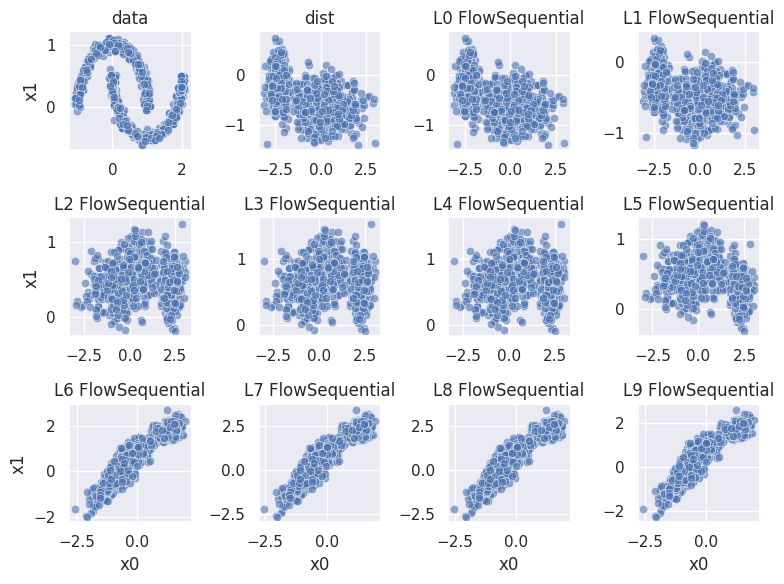

In [39]:
# 展示
glow_mixture.plot(data, n=1000)

## 5.Glow (Part 2)

- Actnorm_2D

In [ ]:
class ActNorm_2D(FlowModule):
    